In [225]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import itertools
import optax
import pandas as pd
import seaborn as sns
from scipy import stats


# Enable float64 precision
jax.config.update("jax_enable_x64", True)
XMIN, XMAX = -10, 10

def generate_data(regression_func, w0, n_samples, noise_std, key, input_dim=1):
    """Generate synthetic data for custom regression."""
    # x = jnp.linspace(-10, 10, n_samples).reshape(-1, 1)
    key, subkey = jax.random.split(key)
    x = jax.random.uniform(key, shape=(n_samples, input_dim), minval=XMIN, maxval=XMAX)
    noise = jax.random.normal(subkey, shape=(n_samples, 1)) * noise_std
    y = regression_func(x, w0) + noise
    return x, y

def negative_log_likelihood(regression_func, w, x, y):
    """Compute negative log-likelihood for custom regression."""
    y_pred = regression_func(x, w)
    return jnp.mean(0.5 * jnp.log(2 * jnp.pi) + 0.5 * (y - y_pred)**2)

def grid_search(regression_func, x, y, w_ranges, n_subdivisions):
    """Perform grid search over the parameter space."""
    w_values = [jnp.linspace(w_min, w_max, n_subdivisions) for w_min, w_max in w_ranges]
    w_grid = jnp.array(jnp.meshgrid(*w_values)).T.reshape(-1, len(w_ranges))
    nll_values = jax.vmap(lambda w: negative_log_likelihood(regression_func, w, x, y))(w_grid)
    return w_grid, nll_values.reshape([n_subdivisions] * len(w_ranges))

def find_mle(regression_func, x, y, w_ranges, method='optax', learning_rate=0.5, num_steps=5000, key=None):
    """Find the Maximum Likelihood Estimate using specified method."""
    if method == 'optax':
        def loss_fn(w):
            return negative_log_likelihood(regression_func, w, x, y)

        optimizer = optax.adam(learning_rate)
        
        if key is None:
            key = jax.random.PRNGKey(0)
        init_params = jax.random.uniform(key, shape=(len(w_ranges),), 
                                         minval=jnp.array([w_min for w_min, _ in w_ranges]),
                                         maxval=jnp.array([w_max for _, w_max in w_ranges]))
        opt_state = optimizer.init(init_params)

        @jax.jit
        def step(params, opt_state):
            loss, grads = jax.value_and_grad(loss_fn)(params)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss

        params = init_params
        for _ in range(num_steps):
            params, opt_state, _ = step(params, opt_state)

        return params
    
    else:
        raise ValueError("Invalid method. Only 'optax' is supported for this model.")

def find_epsilon_region(regression_func, x, y, w_star, w_ranges, epsilon, n_grid=100):
    """Find the epsilon region around w_star."""
    w_grid, nll_values = grid_search(regression_func, x, y, w_ranges, n_grid)
    nll_star = negative_log_likelihood(regression_func, w_star, x, y)
    epsilon_region = w_grid[nll_values.flatten() - nll_star < epsilon / len(x)]
    return epsilon_region

import itertools

def required_subdivisions(regression_func, x, y, w_star, w_ranges, epsilon, max_subdivisions=1024):
    """
    Determine the number of subdivisions required to find a contiguous hypercube
    of 2^d grid points within the epsilon region, using binary search.
    """
    nll_star = negative_log_likelihood(regression_func, w_star, x, y)
    d = len(w_ranges)  # dimension of the parameter space

    def check_contiguous_hypercube(grid):
        """Check if there's a contiguous hypercube of True values in the grid."""
        for index in itertools.product(*[range(grid.shape[i] - 1) for i in range(d)]):
            hypercube = grid[tuple(slice(i, i+2) for i in index)]
            if jnp.all(hypercube):
                return True
        return False

    def check_subdivisions(n):
        """Check if n subdivisions are sufficient."""
        _, nll_values = grid_search(regression_func, x, y, w_ranges, n)
        epsilon_grid = (nll_values - nll_star < epsilon / len(x))
        return check_contiguous_hypercube(epsilon_grid)

    # Handle edge cases
    if not check_subdivisions(max_subdivisions):
        return max_subdivisions  # Even maximum subdivisions are not enough
    if check_subdivisions(2):
        return 2  # Minimum subdivisions are already sufficient

    # Binary search
    low, high = 2, max_subdivisions
    while low <= high:
        mid = (low + high) // 2
        if check_subdivisions(mid):
            if mid == 2 or not check_subdivisions(mid - 1):
                return mid  # mid is the minimum sufficient subdivisions
            high = mid - 1
        else:
            low = mid + 1

    # This line should theoretically never be reached due to the initial checks
    raise ValueError("Binary search failed to find the minimum number of subdivisions.")

def plot_results(regression_func, x, y, w0, w_star, w_ranges, n_subdivisions, epsilon):
    """Plot the results of the experiment."""
    w_grid, nll_values = grid_search(regression_func, x, y, w_ranges, 100)
    epsilon_region = find_epsilon_region(regression_func, x, y, w_star, w_ranges, epsilon)
    
    if len(w_ranges) == 2:  # 2D plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        
        # Contour plot
        w1_values = jnp.linspace(w_ranges[0][0], w_ranges[0][1], 100)
        w2_values = jnp.linspace(w_ranges[1][0], w_ranges[1][1], 100)
        W1, W2 = jnp.meshgrid(w1_values, w2_values)
        
        cs = ax1.contour(W1, W2, nll_values.reshape(100, 100).T, levels=20)
        ax1.clabel(cs, inline=1, fontsize=10)
        ax1.scatter(w0[0], w0[1], color='r', marker='o', s=200, label='True w')
        ax1.scatter(w_star[0], w_star[1], color='b', marker='*', s=200, label='w_star')
        ax1.scatter(epsilon_region[:, 0], epsilon_region[:, 1], marker='x', color='g', alpha=0.5, label='Epsilon Region')
        
        grid_w, _ = grid_search(regression_func, x, y, w_ranges, n_subdivisions)
        ax1.scatter(grid_w[:, 0], grid_w[:, 1], color='purple', marker='.', label='Grid Points', alpha=0.3)
        
        ax1.set_xlabel('w1')
        ax1.set_ylabel('w2')
        ax1.set_title('Negative Log-Likelihood Contour')
        ax1.legend()
        
        # Regression plot
        if x.shape[1] == 1: 
            ax2.scatter(x, y, label='Data')
            x_plot = jnp.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            ax2.plot(x_plot, regression_func(x_plot, w0), 'r-', label='True Function')
            ax2.plot(x_plot, regression_func(x_plot, w_star), 'g--', label='w_star Function')
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.set_title(f'Regression Plot. n={len(x)}')
            ax2.legend()
        elif x.shape[1] == 2:
            x1_values = jnp.linspace(XMIN, XMAX, 100)
            x2_values = jnp.linspace(XMIN, XMAX, 100)
            X1, X2 = jnp.meshgrid(x1_values, x2_values)
            X = jnp.stack([X1, X2], axis=-1)
            Y = regression_func(X, w_star).reshape(100, 100)
            ax2.contourf(X1, X2, Y, levels=20, cmap='viridis', alpha=0.5)
            # ax2.scatter(x[:, 0], x[:, 1], c=y.flatten(), cmap='viridis', label='Data')
            ax2.set_xlabel('x1')
            ax2.set_ylabel('x2')
            ax2.set_title('Regression Plot')
            ax2.legend()

    else:  # 1D plot or higher dimensions
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(x, y, label='Data')
        x_plot = jnp.linspace(x.min(), x.max(), 100).reshape(-1, 1)
        ax.plot(x_plot, regression_func(x_plot, w0), 'r-', label='True Function')
        ax.plot(x_plot, regression_func(x_plot, w_star), 'g--', label='w_star Function')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Regression Plot')
        ax.legend()
    
    plt.suptitle(f'MDL Experiment Results (Subdivisions: {n_subdivisions})')
    plt.tight_layout()
    plt.show()

def run_experiment(regression_func, w0, n_samples, noise_std, w_ranges, epsilon, max_subdivisions=20, seed=0):
    """Run the complete MDL experiment."""
    key = jax.random.PRNGKey(seed)
    key, subkey1, subkey2 = jax.random.split(key, 3)
    x, y = generate_data(regression_func, w0, n_samples, noise_std, subkey1)
    
    w_mle = find_mle(regression_func, x, y, w_ranges, key=subkey2)
    n_subdivisions, w_grid, nll_values = required_subdivisions(regression_func, x, y, w_mle, w_ranges, epsilon, max_subdivisions)
    plot_results(regression_func, x, y, w0, w_mle, w_ranges, n_subdivisions, epsilon)
    print(f"Nll values: {nll_values}")
    return n_subdivisions, w_mle

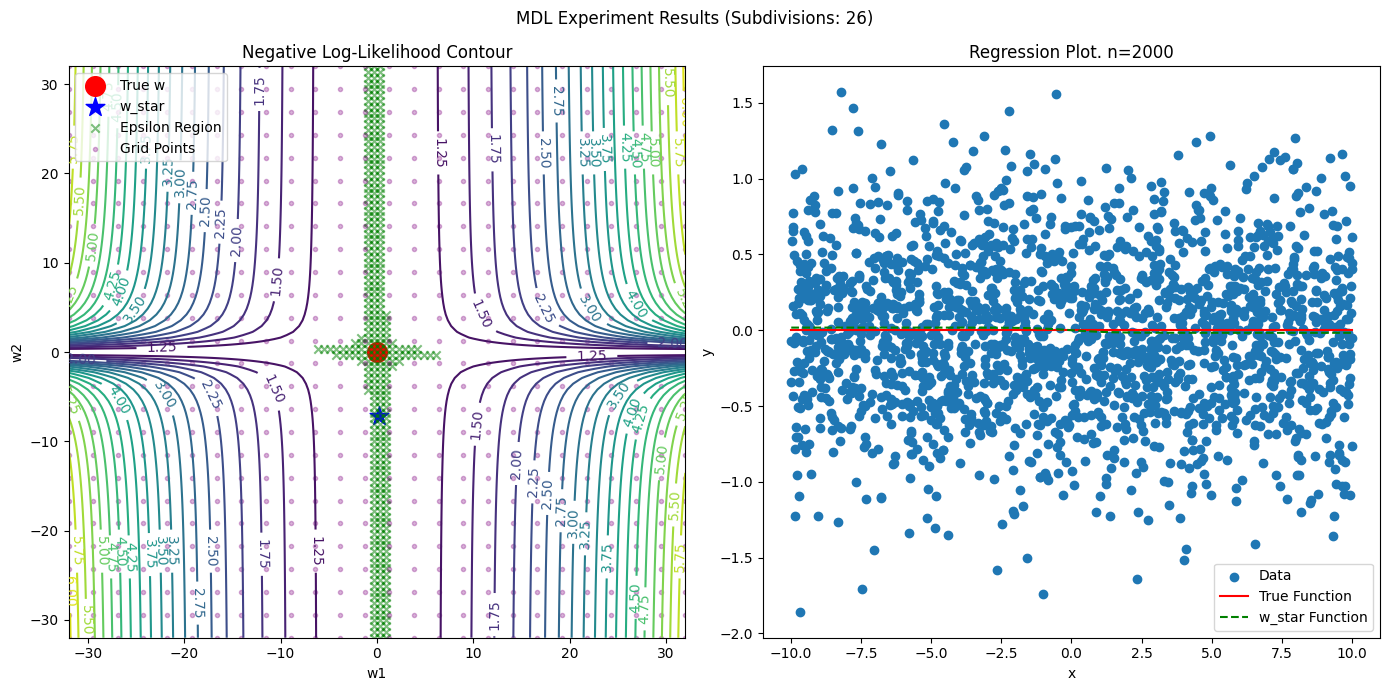

Number of subdivisions required: 26
MLE: [ 0.17170088 -7.12501317]


In [443]:
angle = np.pi / 3
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
displacement = np.array([.1, .1])
@jax.jit
def regression_func(x, w):
    rescale = jnp.array([0.1, 0.1])
    w = w * rescale
    # w = w + displacement
    # w = w @ rotation_matrix.T
    a, b = w
    return a * jnp.tanh(b * x)
    # return (a**2 + b**2 - 1) * x
    # return (a * b**2) * x
    # return a * x + b

# Set experiment parameters
seed=0
max_subdivisions=100
w0 = jnp.array([0.0, 0.0])
# w0 = jnp.array([-1.5, np.pi]) #@ rotation_matrix.T 
# w0 = jnp.array([.1/np.sqrt(2), .1 / np.sqrt(2)]) * 100
# w0 = jnp.array([5.0, 5.0]) 


input_dim = 1
n_samples = 2000
noise_std = 0.5
M = 32
w_ranges = [(-M, M), (-M, M)]  # Ranges for w1 and w2
epsilon = 10.0

# Run the experiment
key = jax.random.PRNGKey(seed)
key, subkey1, subkey2 = jax.random.split(key, 3)
x, y = generate_data(regression_func, w0, n_samples, noise_std, subkey1, input_dim=input_dim)

w_mle = find_mle(regression_func, x, y, w_ranges, method='optax', num_steps=20000, key=subkey2, learning_rate=0.5)
# w_mle = w0
n_subdivisions = required_subdivisions(regression_func, x, y, w_mle, w_ranges, epsilon, max_subdivisions)
plot_results(regression_func, x, y, w0, w_mle, w_ranges, n_subdivisions, epsilon)

print(f"Number of subdivisions required: {n_subdivisions}")
print(f"MLE: {w_mle}")

In [444]:
seed = 42
key = jax.random.PRNGKey(seed)
records = []
# n_samples_list = list(range(5, 300, 5)) + list(range(300, 2001, 50))
n_samples_list = list(range(50, 3500, 100))
# n_samples_list = list(range(2, 100, 2))
for n_samples in n_samples_list:
    key, subkey1, subkey2 = jax.random.split(key, 3)
    x, y = generate_data(regression_func, w0, n_samples, noise_std, subkey1)
    w_mle = find_mle(regression_func, x, y, w_ranges, method='optax', num_steps=20000, key=subkey2, learning_rate=0.5)
    # w_mle = w0
    n_subdivisions = required_subdivisions(regression_func, x, y, w_mle, w_ranges, epsilon, max_subdivisions)
    rec = {
        'n_samples': n_samples,
        'n_subdivisions': n_subdivisions,
        'w_mle': w_mle
    }
    records.append(rec)
    print(f"n_samples: {n_samples}, n_subdivisions: {n_subdivisions}, w_mle: {w_mle}")


n_samples: 50, n_subdivisions: 10, w_mle: [1.30028839 0.23346716]
n_samples: 150, n_subdivisions: 16, w_mle: [-2.65584587e-01  8.65893664e+02]
n_samples: 250, n_subdivisions: 16, w_mle: [1.56047833 0.34570495]
n_samples: 350, n_subdivisions: 22, w_mle: [ 2.01378089 -0.17194139]
n_samples: 450, n_subdivisions: 22, w_mle: [-0.49350131  0.44139779]
n_samples: 550, n_subdivisions: 26, w_mle: [  0.13524061 -66.04469405]
n_samples: 650, n_subdivisions: 26, w_mle: [0.29753285 9.93262879]
n_samples: 750, n_subdivisions: 26, w_mle: [0.10773649 2.56721591]
n_samples: 850, n_subdivisions: 26, w_mle: [  0.1332006  -35.74740777]
n_samples: 950, n_subdivisions: 26, w_mle: [0.31459678 1.55427715]
n_samples: 1050, n_subdivisions: 26, w_mle: [ 0.44201196 -0.08533528]
n_samples: 1150, n_subdivisions: 26, w_mle: [ -0.27761847 -31.41397487]
n_samples: 1250, n_subdivisions: 26, w_mle: [-0.232969   80.73387114]
n_samples: 1350, n_subdivisions: 26, w_mle: [ 0.04209346 -5.46352235]
n_samples: 1450, n_subdivis

Slope (coefficient of proportionality): 4.4430
Intercept: -5.7434
R-squared: 0.5885
P-value: 0.0000
Predicted subdivisions for 1000 samples: 24.95


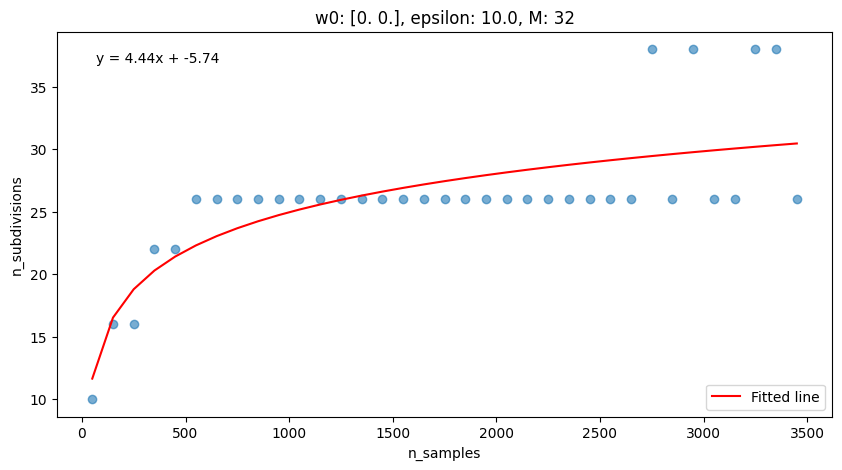

In [446]:

# Prepare the data
df_data = pd.DataFrame(records)
log_n_samples = np.log(df_data['n_samples'])
n_subdivisions = df_data['n_subdivisions']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(log_n_samples, n_subdivisions)

# Print results
print(f"Slope (coefficient of proportionality): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

# Create a plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_data['n_samples'], n_subdivisions, alpha=0.6)
ax.plot(df_data['n_samples'], slope * log_n_samples + intercept, color='red', label='Fitted line')
ax.set_xlabel('n_samples')
ax.set_ylabel('n_subdivisions')
ax.set_title(f"w0: {w0}, epsilon: {epsilon}, M: {M}")
ax.legend()
# ax.set_xscale('log')

# Add the equation to the plot
equation = f'y = {slope:.2f}x + {intercept:.2f}'
ax.text(0.05, 0.95, equation, transform=plt.gca().transAxes, verticalalignment='top')


# If you want to predict n_subdivisions for a given n_samples
n_samples_predict = 1000
predicted_subdivisions = slope * np.log(n_samples_predict) + intercept
print(f"Predicted subdivisions for {n_samples_predict} samples: {predicted_subdivisions:.2f}")

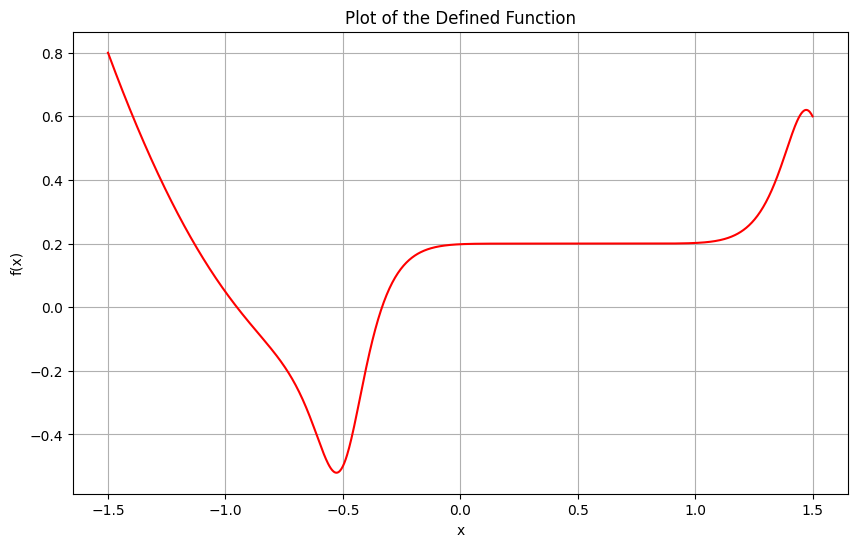

In [422]:
import jax.numpy as jnp
import jax
from jax import grad, vmap
import matplotlib.pyplot as plt

def g(x):
    return (jnp.tanh(10*x) + 1) / 2

def h(x):
    return g(-x + 1) - (1 - g(x + 1))

def f1(x, m):
    return x**2 - m

def f2(x, m, exponent=9):
    return x**exponent + m

def f(x, a, m):
    return f1(x + a, m) * g(-(x + a)) + f2(x - a, m) * h(x - a)

# Vectorize the function for efficient computation
vf = jax.vmap(f, in_axes=(0, None, None))

# Set up the plot
M = 1.5
x = jnp.linspace(-M, M, 1000)
a = 0.5
m = 0.2

# Compute the function values
y = vf(x, a, m)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r-')
plt.grid(True)
plt.title('Plot of the Defined Function')
plt.xlabel('x')
plt.ylabel('f(x)')

# Show the plot
plt.show()

# If you want to save the plot instead of showing it, use:
# plt.savefig('function_plot.png')

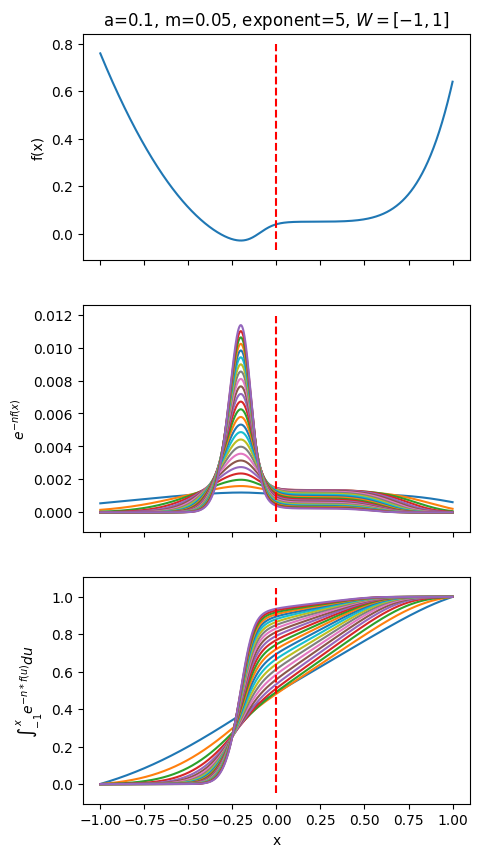

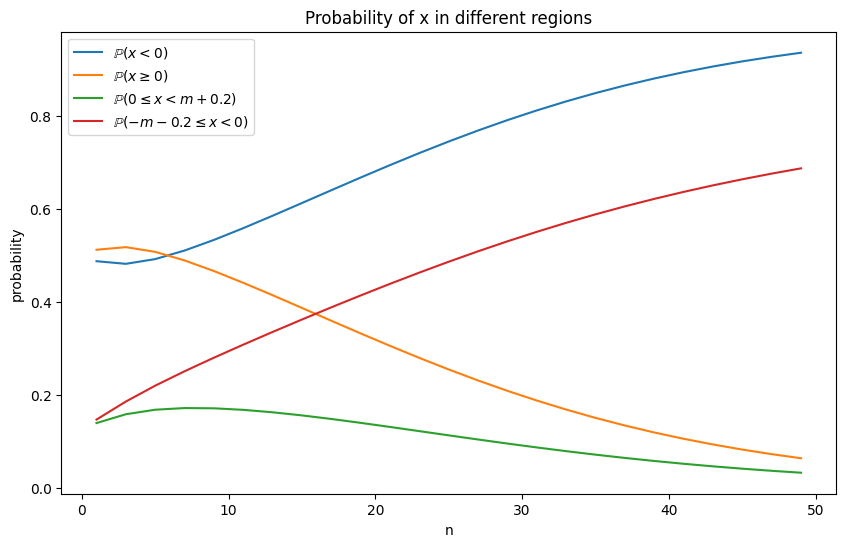

In [497]:
exponent = 5
scale = 0.01
a = 0.1
m = 0.05
# f = lambda x: x**exponent * scale
f = lambda x: f1(x + a, m) * g(-(x + a)) + f2(x - a, m, exponent=exponent) * h(x - a - 0.8)
# def f(x):
#     # x = 5 * x
#     a = 0.5
#     y = np.zeros_like(x)
#     y[x < 0] = 2 * x[x < 0]
#     y[x >= 0] = 0.5 * x[x >= 0]
#     # y[x < 0] = (x[x < 0] + a)**2 - a**2
#     # y[x >= 0] = x[x >= 0]**4
#     return y

M = 1
xs = np.linspace(-M, M, 1000)
ys = f(xs)

fig, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
ax = axes[0]
ax.plot(xs, ys)
ymin, ymax = ax.get_ylim()
ax.vlines(0, ymin, ymax, color='r', linestyle='--', label='ys=0')
ax.set_ylabel("f(x)")
ax.set_title(f"a={a}, m={m}, exponent={exponent}, $W = [-{M}, {M}]$")


ax = axes[1]
ax2 = axes[2]
records = []
for n in range(1, 50, 2):
    expys = np.exp(-n * ys) / np.sum(np.exp(-n * ys))
    ax.plot(xs, expys, label=f"exp(-{n}*f(x))")
    ax2.plot(xs, np.cumsum(expys), label=f"cumsum(exp(-{n}*f(x)))")
    rec = {
        'n': n,
        'p1': np.sum(expys[xs < 0]),
        'p2': np.sum(expys[xs >= 0]),
        "p3": np.sum(expys[(xs >=0) & (xs <= m + 0.2)]),
        "p4": np.sum(expys[(xs <=0) & (xs >= -m - 0.2)]),
    }
    records.append(rec)

ax.set_ylabel("$e^{-n f(x)}$")
ax2.set_ylabel("$\int_{-1}^x e^{-n*f(u)} du$")
ymin, ymax = ax.get_ylim()
ax.vlines(0, ymin, ymax, color='r', linestyle='--', label='ys=0')

ymin, ymax = ax2.get_ylim()
ax2.vlines(0, ymin, ymax, color='r', linestyle='--', label='ys=0')
ax2.set_xlabel("x")

fig, ax = plt.subplots(figsize=(10, 6))
df = pd.DataFrame(records)
ax.plot(df['n'], df['p1'], label='$\mathbb{P}(x < 0)$')
ax.plot(df['n'], df['p2'], label='$\mathbb{P}(x \geq 0)$')
ax.plot(df['n'], df['p3'], label='$\mathbb{P}(0 \leq x < m + 0.2)$')
ax.plot(df['n'], df['p4'], label='$\mathbb{P}(-m - 0.2 \leq x < 0)$')
ax.set_title("Probability of x in different regions")
ax.set_xlabel("n")
ax.set_ylabel("probability")
ax.legend()


# fig.suptitle(f"$f(x) = {scale} x^{exponent}$, $W = [-{M}, {M}]$")


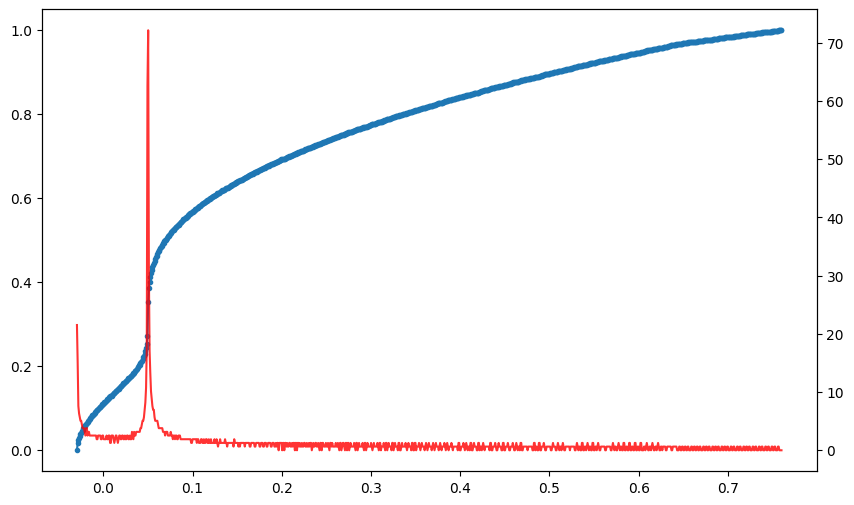

In [498]:
ts = np.linspace(ys.min(), ys.max(), 1000)
vol_t = np.array(
    [np.sum(ys < t) / len(ys) for t in ts]
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts, vol_t, ".-")

ax = ax.twinx()
dvol_dt = np.gradient(vol_t, ts[1] - ts[0])
ax.plot(ts, dvol_dt, "r-", alpha=0.8)


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_37893/3370049193.py:2: RuntimeWarning: invalid value encountered in power
  return (1 - (-1)**(x + 1/3))/(x + 1/3)


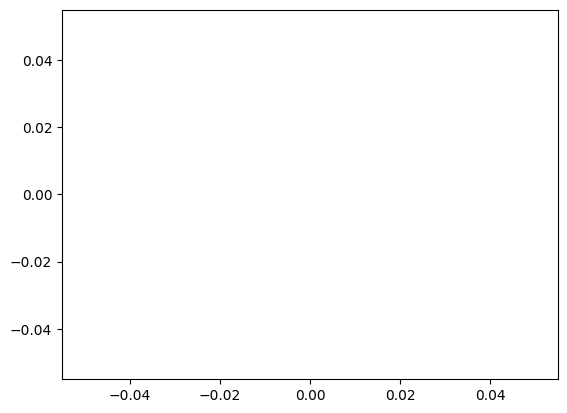

In [496]:
def f(x):
    return (1 - (-1)**(x + 1/3))/(x + 1/3)


x = np.linspace(-1, 1, 1000)
y = f(x)
plt.plot(x, y)